In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

import torch
from torch.utils.data import Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class EMGDataset(Dataset):
    def __init__(self, signals, labels):
        self.signals = signals 
        self.labels = labels

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        x = self.signals[idx]  # Get the signal
        x = torch.tensor(x, dtype=torch.float32)  # Convert to PyTorch tensor
        x = x.unsqueeze(0)  # Add channel dimension: (1, 129, 1462)
        x = x.repeat(32, 1, 1)  # Repeat to have 32 channels (if appropriate)
        y = self.labels[idx]
        return x, torch.tensor(y, dtype=torch.long)  # Only return tensors



In [13]:
import numpy as np
import wfdb
import os

data_folder = '_your_path'

signals = []
labels = []

for session in range(1, 2):
 for subject in range(1, 44):
     for gesture in range(1, 18):
         for trial in range(1, 8):
            record_name = f"session{session}_participant{subject}_gesture{gesture}_trial{trial}"
            record_path = os.path.join(data_folder, f"Session{session}/session{session}_participant{subject}/{record_name}")
            record = wfdb.rdrecord(record_path, sampto=1000) # original 10240 samples or 2048hz by 5 seconds
            signals.append(record.p_signal)
            labels.append(gesture-1)  # Append the gesture label
signals = np.array(signals)
labels = np.array(labels)

In [3]:
from scipy import signal

def generate_spectrogram(np_signal):
    f, t, Sxx = signal.spectrogram(np_signal, fs=2048)
    return Sxx

def create_spectrograms(signals):
    spectrograms = []
    for signal in signals:
        spec = generate_spectrogram(signal.flatten())
        spectrograms.append(spec)
    return np.array(spectrograms)


In [4]:
import torchvision.models as models
import torch.nn as nn

class GestureClassifier(nn.Module):
    def __init__(self):
        super(GestureClassifier, self).__init__()
        # Load the pre-trained DenseNet model
        self.densenet = models.densenet121()

        # Change the first layer to accept 32 channels instead of 3
        self.densenet.features.conv0 = nn.Conv2d(
            in_channels=32,  # Change from 3 to 32 channels
            out_channels=64, # The number of output channels
            kernel_size=(7, 7), 
            stride=(2, 2), 
            padding=(3, 3), 
            bias=False
        )
        
        # Reinitialize the classifier for 17 gestures
        self.densenet.classifier = nn.Linear(self.densenet.classifier.in_features, 17)

    def forward(self, x):
        return self.densenet(x)



In [5]:
from torch.optim import Adam

def train_model(model, dataloader, num_epochs=25):
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001)
    model.train()
    
    for epoch in range(num_epochs):
        for inputs, labels in dataloader:
            inputs = inputs.to(device)  # Move inputs to CUDA
            labels = labels.to(device)  # Move labels to CUDA
            outputs = model(inputs)  # This should now work without errors
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


In [6]:
def test_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)  # Move inputs to CUDA
            labels = labels.to(device)  # Move labels to CUDA
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Accuracy: {accuracy * 100:.2f}%')


In [7]:
# Hyperparameters
BATCH_SIZE = 8
NUM_EPOCHS = 25

# Load the dataset
spectrograms = create_spectrograms(signals)

# Create the dataset and dataloaders
emg_dataset = EMGDataset(spectrograms, labels)
train_size = int(0.8 * len(emg_dataset))
test_size = len(emg_dataset) - train_size
train_dataset, test_dataset = random_split(emg_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize and train the model
model = GestureClassifier().to(device)
train_model(model, train_loader)

# Evaluate the model
test_model(model, test_loader)


Accuracy: 24.12%


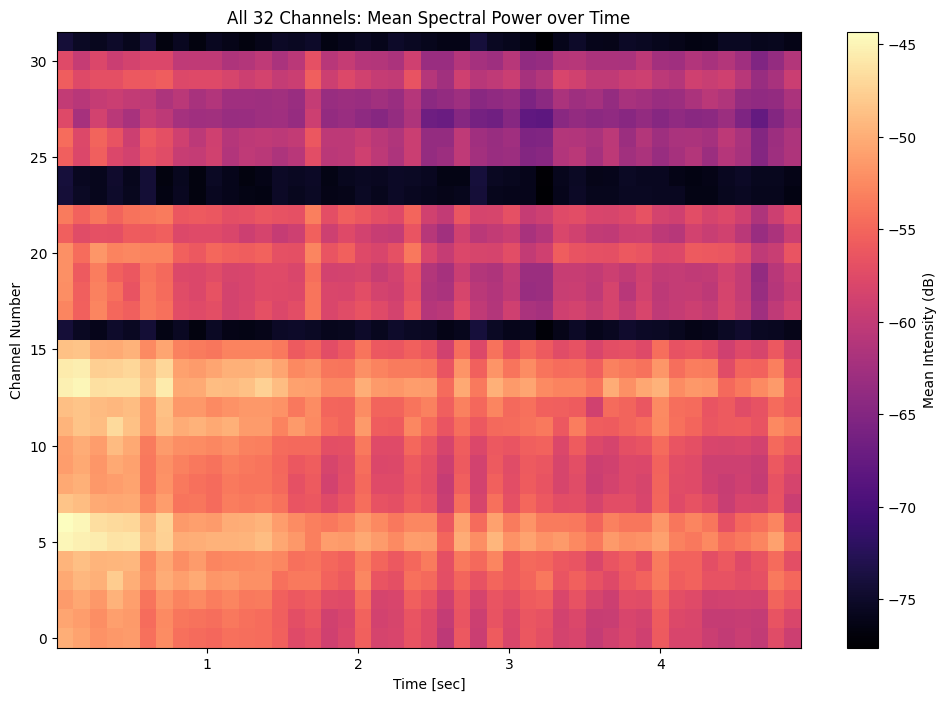

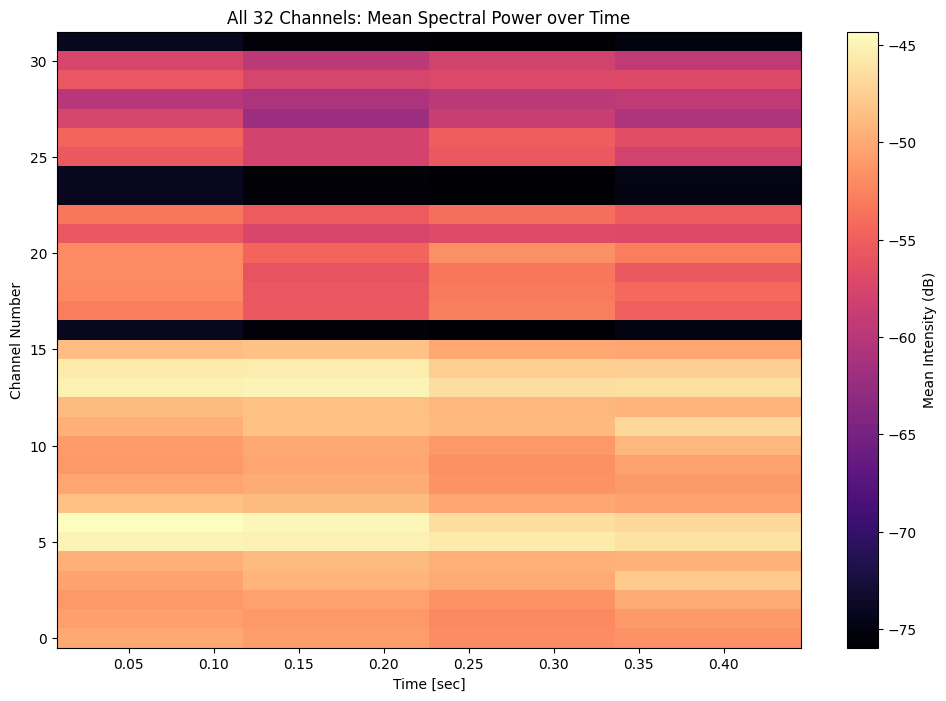

In [15]:
import matplotlib.pyplot as plt

def plot_combined_spectrogram(record, fs=2048):
    # Sxx_list will store the power for each channel
    all_pwr = []
    
    for i in range(record.p_signal.shape[1]):
        f, t, Sxx = signal.spectrogram(record.p_signal[:, i], fs=fs)
        # Take the mean across frequencies to get 'Power vs Time' for this channel
        # Or select a specific frequency band of interest
        channel_power = 10 * np.log10(np.mean(Sxx, axis=0)) 
        all_pwr.append(channel_power)

    # Convert list to 2D array [Channels x Time]
    combined_data = np.array(all_pwr)

    plt.figure(figsize=(12, 8))
    plt.pcolormesh(t, np.arange(32), combined_data, shading='auto', cmap='magma')
    
    plt.title('All 32 Channels: Mean Spectral Power over Time')
    plt.ylabel('Channel Number')
    plt.xlabel('Time [sec]')
    plt.colorbar(label='Mean Intensity (dB)')
    plt.show()

file_test = f"{data_folder}/Session1/session1_participant1/session1_participant1_gesture1_trial1"
record = wfdb.rdrecord(file_test, sampto=10240)
plot_combined_spectrogram(record)

file_test = f"{data_folder}/Session1/session1_participant1/session1_participant1_gesture1_trial1"
record = wfdb.rdrecord(file_test, sampto=1000)
plot_combined_spectrogram(record)
